In [1]:
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf
%matplotlib inline

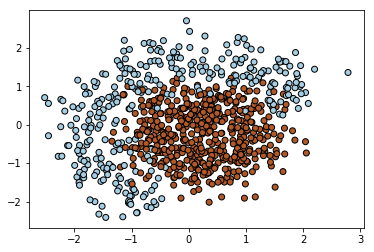

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [3]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))  
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [5]:
def expand(X):
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    X_ = tf.concat([X, X ** 2, X0 * X1, tf.ones_like(X0, dtype=tf.float64)], axis=1)
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    X = expand(X)
    wTx = tf.matmul(X, tf.expand_dims(w, 1))
    result = tf.where(wTx == 0, tf.ones_like(wTx), tf.sign(wTx))
    with tf.Session() as sess:
        return sess.run(result)

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [6]:
def compute_loss(X, Y, W):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    W = tf.expand_dims(W, 1)
    X = expand(X)
    Y = tf.expand_dims(Y, 1)
    wTx = tf.matmul(X, W)
    value_ = Y * wTx
    diff = tf.subtract(tf.ones_like(Y), value_)
    max_ = tf.maximum(tf.zeros_like(Y), diff)
    return tf.reduce_mean(max_)


def compute_grad(X, Y, W):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    W = tf.expand_dims(W, 1)
    X = expand(X)
    Y = tf.expand_dims(Y, 1)
    wTx = tf.matmul(X, W)
    value_ = Y * wTx
    diff = tf.subtract(tf.ones_like(Y), value_)
    # value_ = tf.ones_like(y, dtype=tf.float64) - y * tf.matmul(X, tf.expand_dims(w, 1))
    mask = tf.where(diff >= 0, tf.ones_like(diff), tf.zeros_like(diff))
    return tf.reduce_mean(-mask * Y * X, axis=0) #tf.reduce_mean(tf.matmul(- mask * tf.expand_dims(Y, 1), X), axis=0)

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

In [7]:
w = np.array([1, 0, 0, 0, 0, 0], dtype=np.float64)

X_ph = tf.placeholder(dtype=tf.float64, shape=[None, 2], name="X")
Y_ph = tf.placeholder(dtype=tf.float64, shape=[None], name="Y")
W_ph = tf.placeholder(dtype=tf.float64, shape=[6],name="W")

loss_op = compute_loss(X_ph, Y_ph, W_ph)
grad_op = compute_grad(X_ph, Y_ph, W_ph)

alpha = 0.1  # learning rate
param_update_op = W_ph - grad_op * alpha

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

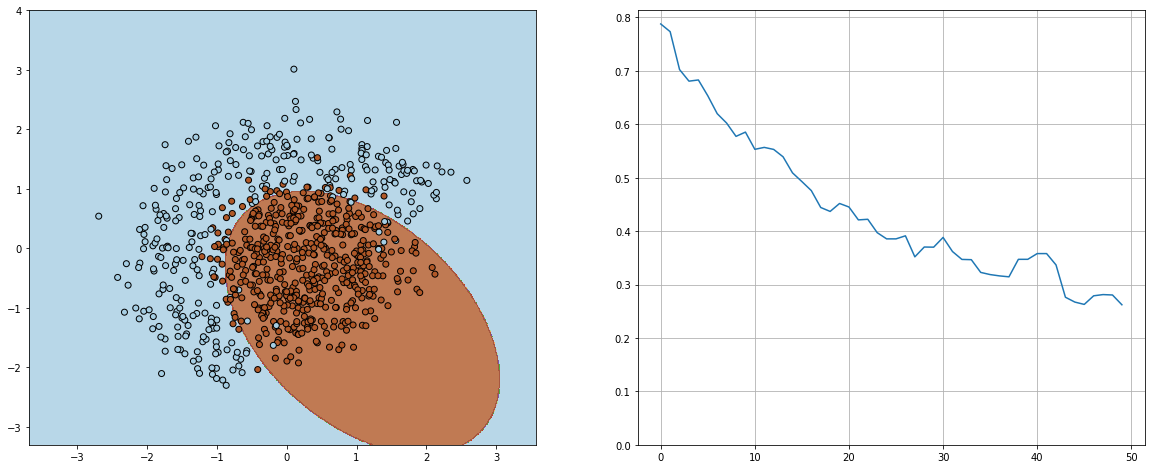

In [7]:
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        batch_loss = sess.run(loss_op, feed_dict={X_ph: X, Y_ph: y, W_ph: w})
        loss[i] = batch_loss
        
        w_new = sess.run(param_update_op, feed_dict={X_ph: X[ind, :], Y_ph: y[ind],  W_ph: w})
        w = w_new

visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

In [10]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)
v = np.zeros(6, dtype=np.float32)

alpha = 0.1 # learning rate
mu    = 0.4 # momentum

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

V_ph = tf.placeholder(dtype=tf.float64, name='momentum')
V_op = mu * V_ph - alpha * grad_op
param_update_op = V_op + W_ph

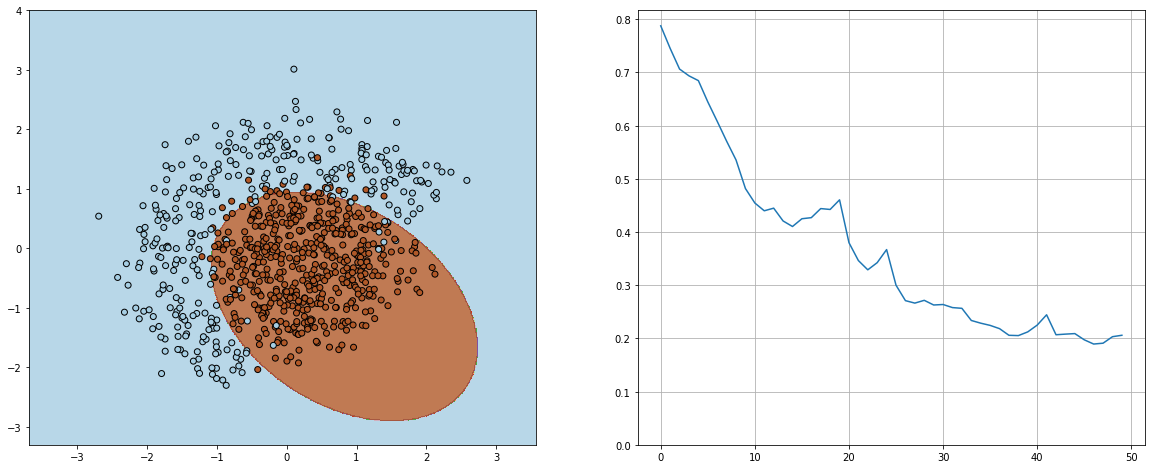

In [14]:
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        batch_loss = sess.run(loss_op, feed_dict={X_ph: X, Y_ph: y, W_ph: w})
        loss[i] = batch_loss        
        w, v = sess.run([param_update_op, V_op], feed_dict={X_ph: X[ind, :], Y_ph: y[ind],  W_ph: w, V_ph: v})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

In [11]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)
v = np.zeros(6, dtype=np.float32)

alpha = 0.1 # learning rate
mu    = 0.4 # momentum

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

W_new = W_ph + mu * V_ph
grad_oper = compute_grad(X_ph, Y_ph, W_new)

V_op = mu * V_ph - alpha * grad_oper
param_update_op = V_op + W_ph

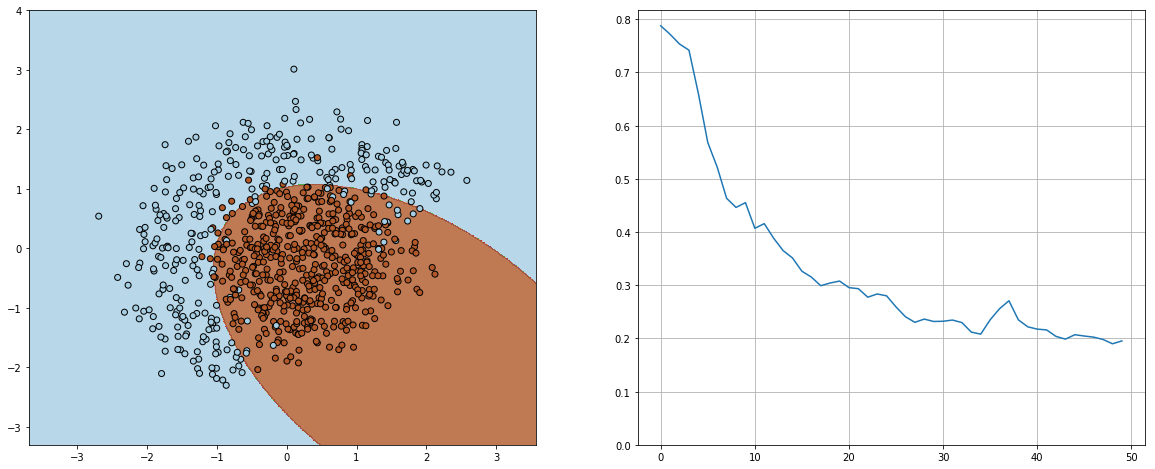

In [19]:

plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        batch_loss = sess.run(loss_op, feed_dict={X_ph: X, Y_ph: y, W_ph: w})
        loss[i] = batch_loss        
        w, v = sess.run([param_update_op, V_op], feed_dict={X_ph: X[ind, :], Y_ph: y[ind],  W_ph: w, V_ph: v})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaGrad:

In [13]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)
c = np.zeros(6, dtype=np.float32)

alpha = 0.2 # learning rate
mu    = 0.3 # momentum
eps = 1e-8  # A small constant for numerical stability

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)


C_ph = tf.placeholder(dtype=tf.float64, name='C')
C_op = C_ph + (grad_op ** 2)
param_update_op = W_ph - (alpha / (tf.sqrt(C_op) + eps) ) * grad_op


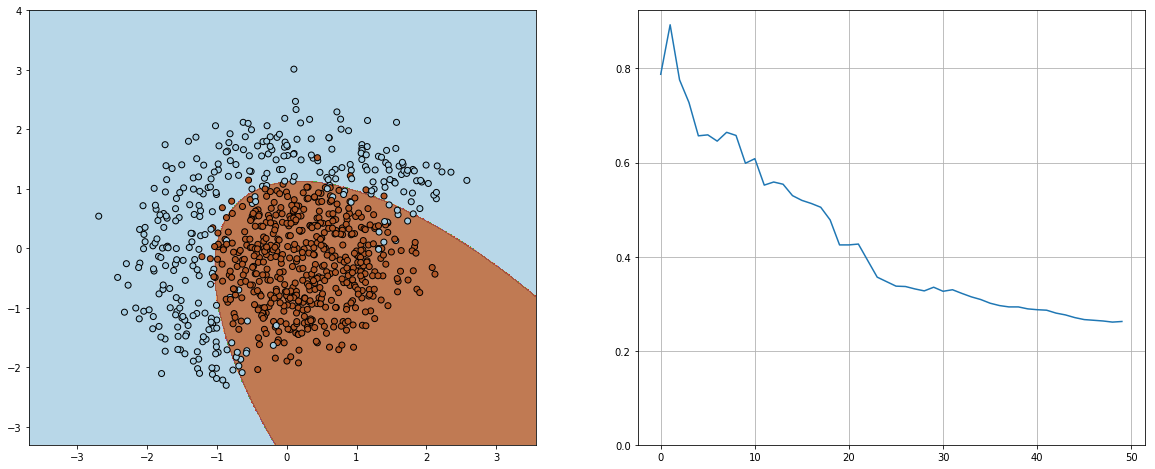

In [32]:
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        batch_loss = sess.run(loss_op, feed_dict={X_ph: X, Y_ph: y, W_ph: w})
        loss[i] = batch_loss        
        w, c = sess.run([param_update_op, C_op], feed_dict={X_ph: X[ind, :], Y_ph: y[ind],  W_ph: w, C_ph: c})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaDelta:

In [14]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)
c = np.zeros(6, dtype=np.float32)

alpha = 0.1 # learning rate
beta = 0.8
mu    = 0.6 # momentum
eps = 1e-9  # A small constant for numerical stability


n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)

C_op =   beta * C_ph + (1- beta)*(grad_op ** 2)
param_update_op = W_ph - (alpha / (tf.sqrt(C_op) + eps) ) * grad_op

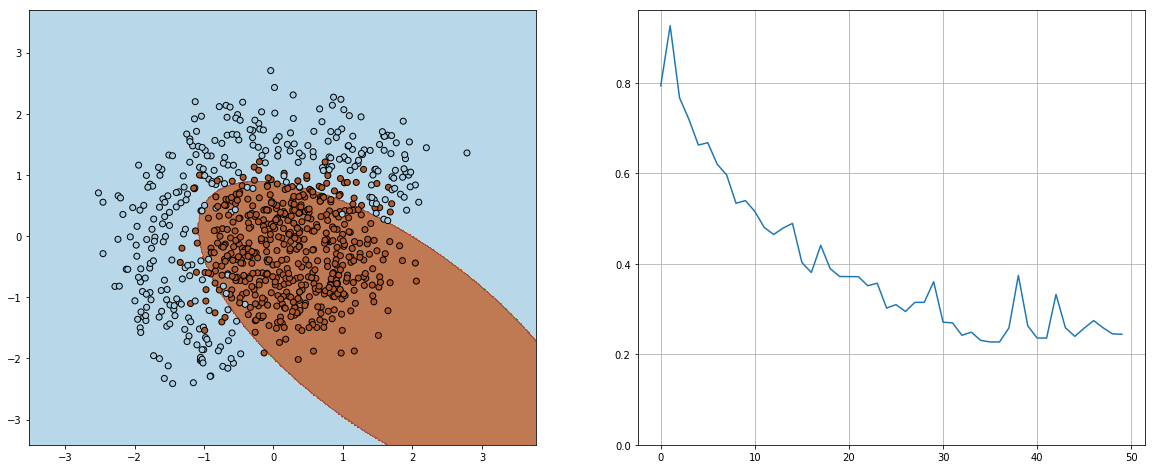

In [15]:

plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        batch_loss = sess.run(loss_op, feed_dict={X_ph: X, Y_ph: y, W_ph: w})
        loss[i] = batch_loss        
        w, c = sess.run([param_update_op, C_op], feed_dict={X_ph: X[ind, :], Y_ph: y[ind],  W_ph: w, C_ph: c})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

In [45]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)
c = np.zeros(6, dtype=np.float32)
v = np.zeros(6, dtype=np.float32)

alpha = 0.1 # learning rate
beta = 0.2
mu    = 0.2 # momentum
eps = 1e-8 # A small constant for numerical stability


n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)


V_oper =  mu * V_ph + (1 - mu) * grad_op
C_op =   beta * C_ph + (1- beta)*(grad_op ** 2)
param_update_op = W_ph - (alpha / (tf.sqrt(C_op) + eps) ) * V_oper

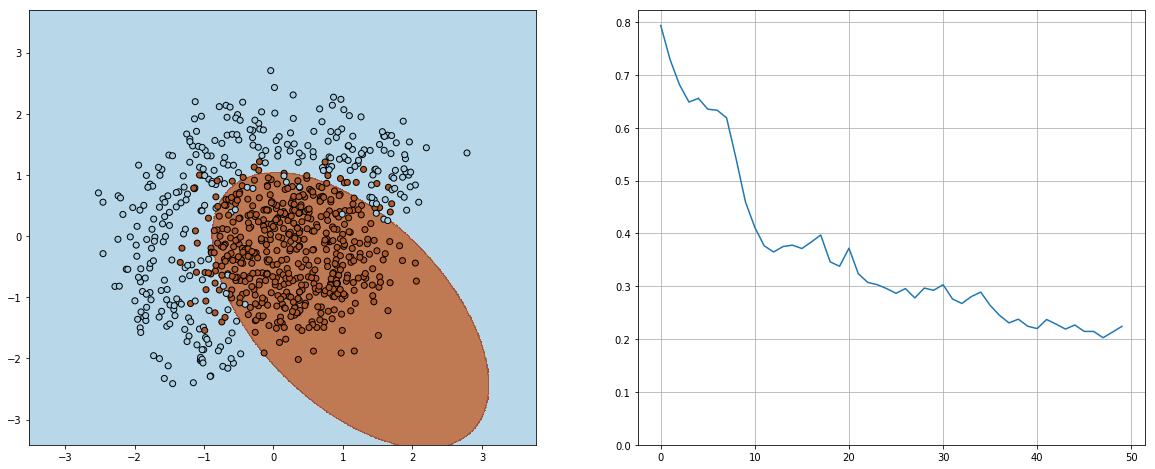

In [46]:

plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        batch_loss = sess.run(loss_op, feed_dict={X_ph: X, Y_ph: y, W_ph: w})
        loss[i] = batch_loss        
        w, c, v = sess.run([param_update_op, C_op, V_oper], feed_dict={X_ph: X[ind, :], Y_ph: y[ind], 
                                                                     W_ph: w, V_ph : v, C_ph: c})

visualize(X, y, w, loss, n_iter)
plt.clf()